#  Credit Card Fraud Detection — A Pipeline Journey  

## The Story  
Less than **0.2% of transactions are fraudulent** — yet they cost banks **billions of dollars every year**.  
Detecting fraud is like finding a needle in a haystack: only **492 frauds out of 284,807 transactions** in this dataset.  

This project builds a pipeline that **learns from time-based patterns and hidden signals** to flag fraud in real-world credit card payments.  
Think of it as a **first line of defense** for banks, where every decision threshold is a trade-off:  
catching more fraudsters vs. minimizing false alarms that annoy customers.  

---

## The Approach  
- **Dataset:** 284,807 transactions (200k+ train, 50k+ test) with extreme imbalance (fraud ≈ 0.17%).  
- **Methodology:**  
  - **EDA:** Understanding distributions of transaction amounts and temporal behavior (hours, day-parts).  
  - **Feature Engineering:** Derived `Hour`, `Night_transaction`, `Business_hours`, and `log(Amount)` to capture human + business patterns.  
  - **Models:** Logistic Regression (with SMOTE/Under-sampling), Random Forest, XGBoost, plus **Isotonic Calibration** with TimeSeries CV.  
  - **Decision Tuning:** Thresholds tuned either for **Precision ≥90%** (fewer false positives) or for **minimum financial cost** (FN = $200, FP = $5).  
- **Key Metrics:** AUPRC, ROC-AUC, Brier Score, Recall@P90, Realized Cost.  

---

## The Insights  

- **Random Forest** achieved the highest test performance with **AUPRC ≈ 0.813**, followed by **XGBoost ≈ 0.792**, then **Calibrated XGBoost ≈ 0.762**, and **Logistic ≈ 0.742**.  
- At the **Precision ≥90%** operating point (chosen on validation and applied to test), **Calibrated XGBoost** delivered **Precision ≈ 0.92** with **Recall ≈ 0.62** (TP=46, FP=4, FN=28).  
- Using the **Min-Cost threshold** (FN = \$200, FP = \$5) reduced the **realized cost** on the test set from **\$5,620** (P≥90% threshold) to **\$3,315** (min-cost threshold).  
- **Sampling** improved Logistic Regression under extreme imbalance: **SMOTE / SMOTE+Tomek** lifted test AUPRC to **≈0.771** vs **≈0.707** without sampling, and boosted **Recall@P90** from ~0.46 to ~0.73.  
- Although **ROC-AUC scores** were all very high (>0.93), **AUPRC** provided a more realistic view under severe imbalance.  
- The pipeline (time-aware split, probability **calibration**, and **business-aligned thresholds**) maps model scores to **actionable decisions**, and can be adapted to real-time monitoring where teams balance customer experience with loss prevention.  


In [3]:
%%capture
%pip install -q --upgrade scikit-learn==1.4.2 imbalanced-learn==0.12.3


# Import Libraries

In [4]:
import warnings, os, json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, auc,
    f1_score, precision_score, recall_score, confusion_matrix, brier_score_loss
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
sns.set_context("notebook")
plt.rcParams["figure.figsize"]=(10,5)

SEED = 42
np.random.seed(SEED)

## Load Data

In [5]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

## Initial Data Exploration

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.175161e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.369007e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.094852e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,1.021879e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.500885e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.620335e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.149614e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.426963e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [9]:
print("Shape:", df.shape)


Shape: (284807, 31)


# Data Cleaning

In [10]:
print(df.columns.tolist())


['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


## Check missing values


In [11]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [12]:
print('Duplicates:', df.duplicated().sum())
df.drop_duplicates(inplace=True)


Duplicates: 1081


# Feature Engineering

In [13]:
df['Hour'] = ((df['Time']// 3600) % 24).astype(int)
df['Night_transaction'] = (df['Hour'].isin([22, 23, 0, 1, 2, 3, 4, 5])).astype(int)
df['Business_hours'] = (df['Hour'].between(9, 17)).astype(int)

In [14]:
df['_log_amount'] = np.log1p(df['Amount'])
features = [c for c in df.columns if c.startswith("V")] + ['Amount','Hour','_log_amount','Night_transaction','Business_hours']
target = 'Class'  


In [15]:
print("Shape:", df.shape, "Fraud prevalence:", df[target].mean())

Shape: (283726, 35) Fraud prevalence: 0.001667101358352777


# Exploratory Data Analysis (EDA)

## Amount distribution

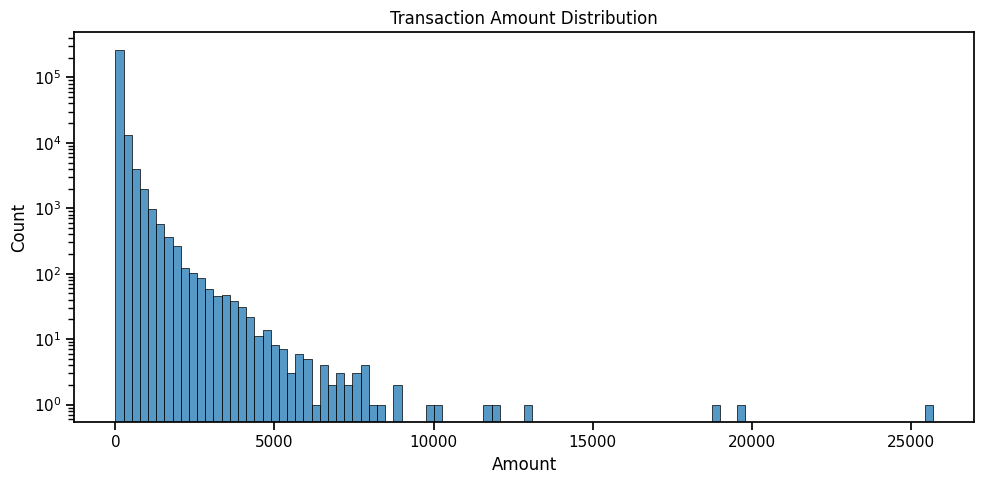

In [16]:
sns.histplot(df["Amount"], bins=100, log_scale=(False, True))
plt.title("Transaction Amount Distribution")
plt.tight_layout()
plt.show()

## Log-Transformed Amount Distribution

Text(0.5, 0, 'log1p(Amount)')

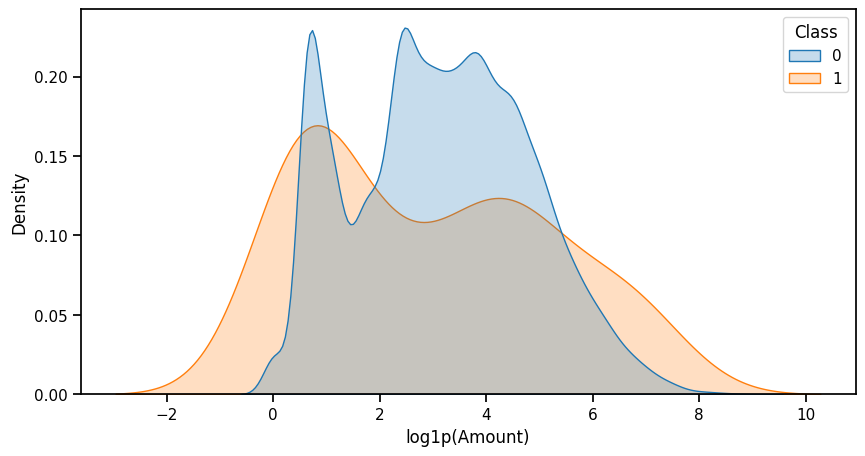

In [17]:
sns.kdeplot(
    data=df.sample(min(40000, len(df)), random_state=SEED),
    x="_log_amount", hue="Class", fill=True, common_norm=False
)
plt.xlabel("log1p(Amount)")


## Histogram log1p(amount)

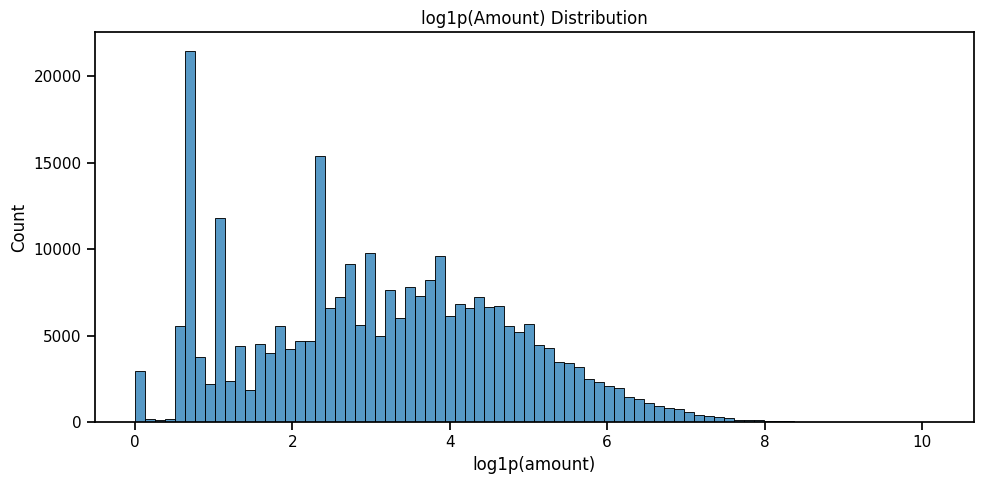

In [18]:
sns.histplot(df["_log_amount"], bins=80)
plt.xlabel("log1p(amount)")
plt.title("log1p(Amount) Distribution")
plt.tight_layout()
plt.show()

## Fraud Rate by Hour

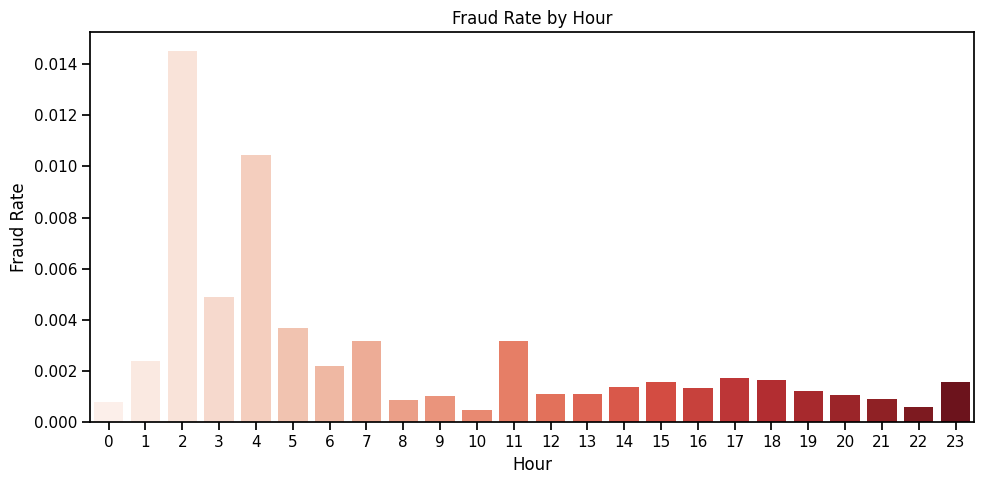

In [19]:
fraud_by_hour = df.groupby("Hour")["Class"].mean()
sns.barplot(x=fraud_by_hour.index, y=fraud_by_hour.values, palette="Reds")
plt.title("Fraud Rate by Hour")
plt.xlabel("Hour")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()

## Transactions per Hour

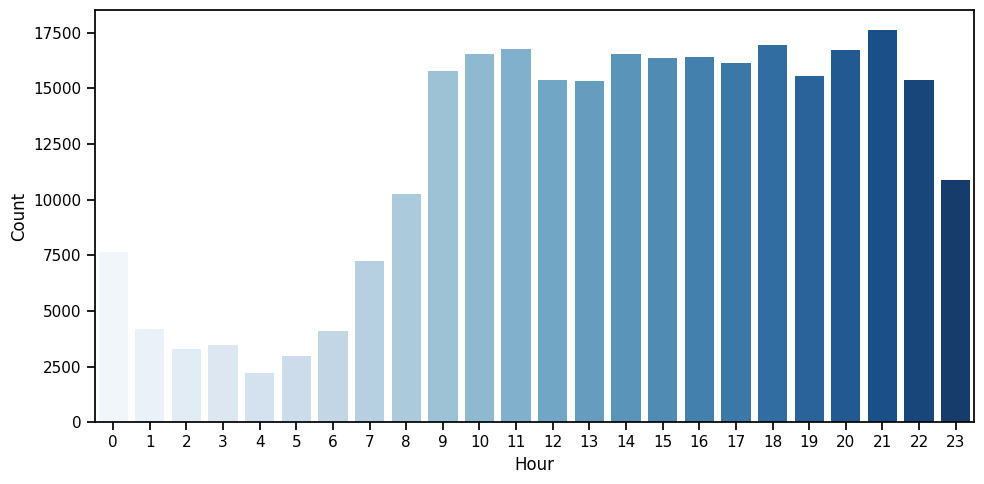

In [20]:
tx_by_hour = df.groupby("Hour")["Class"].count()
sns.barplot(x=tx_by_hour.index, y=tx_by_hour.values, palette='Blues')
plt.xlabel('Hour')
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Boxplot: Amount by Class

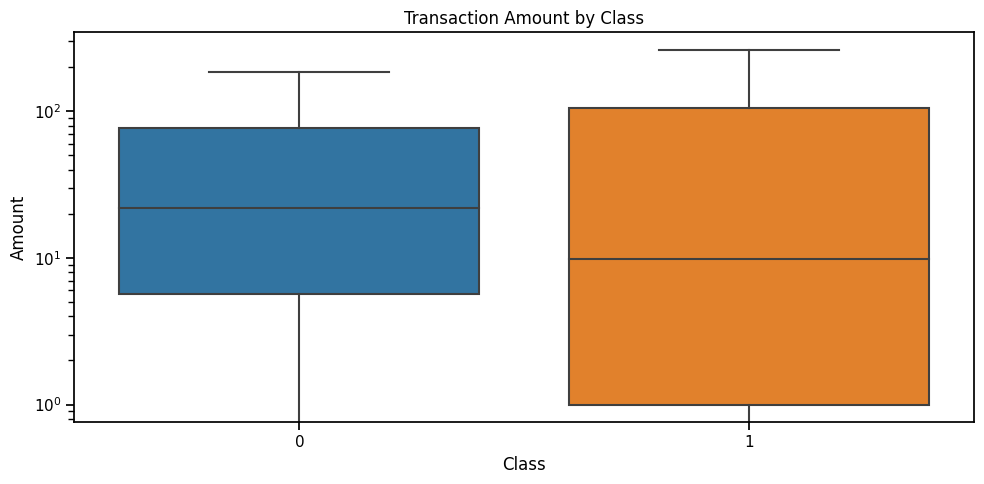

In [21]:
sns.boxplot(x= "Class", y="Amount" , data=df , showfliers=False)
plt.yscale("log")
plt.title("Transaction Amount by Class")
plt.tight_layout()
plt.show()

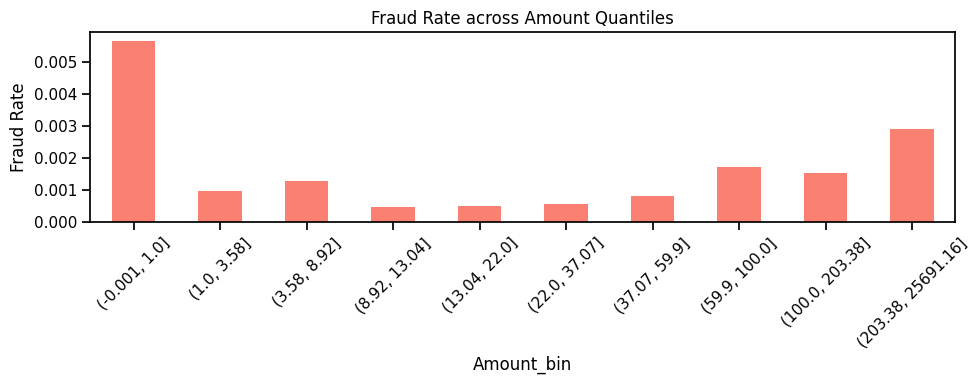

In [22]:
df["Amount_bin"] = pd.qcut(df["Amount"], q=10, duplicates="drop")
fraud_rate_bins = df.groupby("Amount_bin")["Class"].mean()

fraud_rate_bins.plot(kind="bar", color="salmon", figsize=(10,4))
plt.title("Fraud Rate across Amount Quantiles")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()


# Correlation matrix 

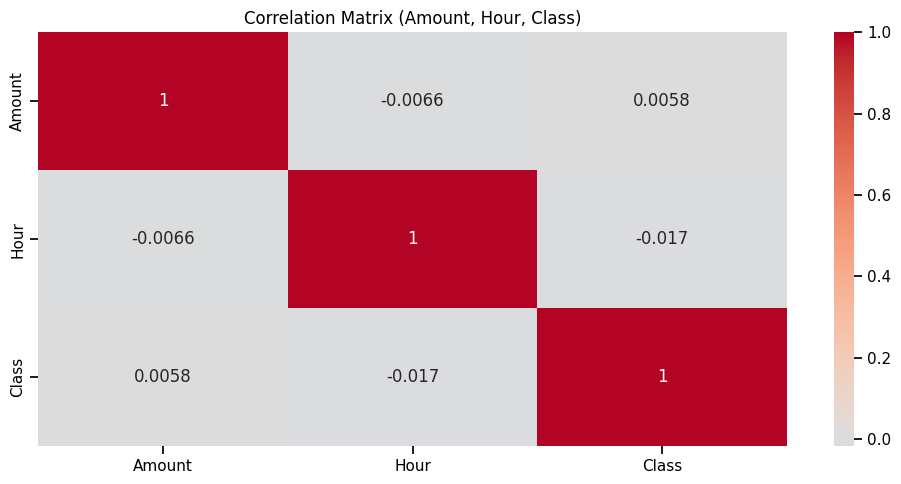

In [23]:
sns.heatmap(df[["Amount","Hour","Class"]].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Amount, Hour, Class)")
plt.tight_layout()
plt.show()


## Countplot for Class

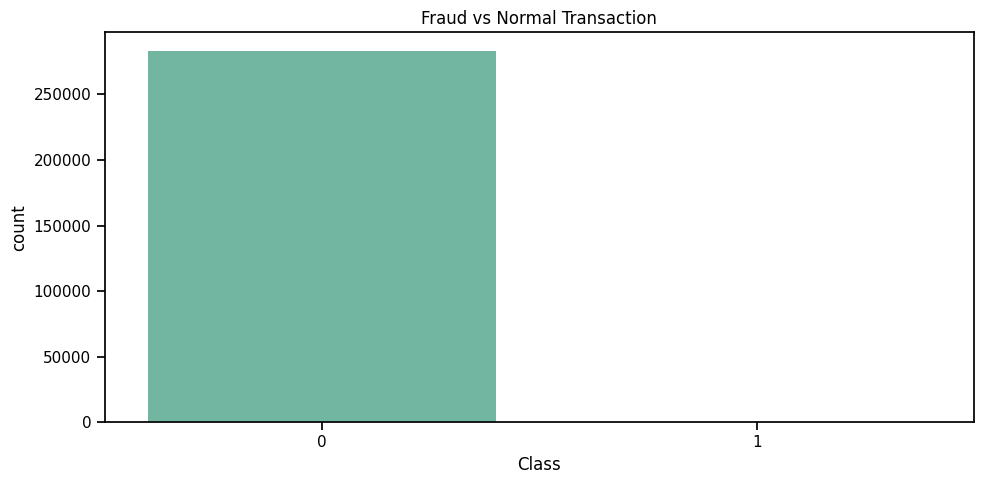

In [24]:
sns.countplot(x='Class', data=df, palette="Set2")
plt.title("Fraud vs Normal Transaction")
plt.tight_layout()
plt.show()

## Time Segments (Morning / Afternoon / Evening / Night)

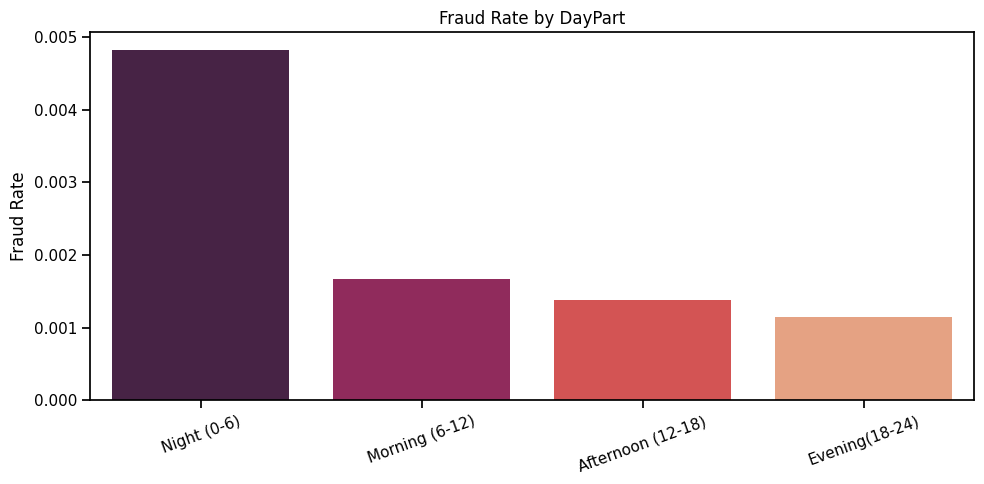

In [25]:
bins = [0,6,12,18,24]
labels = ["Night (0-6)", "Morning (6-12)", "Afternoon (12-18)", "Evening(18-24)"]
df["DayPart"] = pd.cut(df["Hour"], bins=bins, labels=labels, right=False, include_lowest=True)

fraud_by_part  = df.groupby("DayPart")["Class"].mean().reindex(labels)

sns.barplot(x=fraud_by_part.index, y=fraud_by_part.values, palette="rocket")
plt.xticks(rotation=20)
plt.title("Fraud Rate by DayPart")
plt.xlabel("")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()

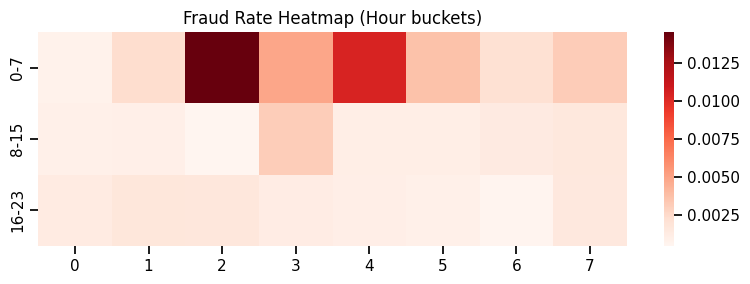

In [26]:
hour_rate = df.groupby("Hour")["Class"].mean().reindex(range(24))
plt.figure(figsize=(8, 3))
sns.heatmap(hour_rate.values.reshape(3,8) , annot=False, cmap="Reds",cbar=True)
plt.title("Fraud Rate Heatmap (Hour buckets)")
plt.yticks([0.5,1.5,2.5], ["0-7", "8-15", "16-23"])
plt.tight_layout()
plt.show()

## Barplot Fraud vs Normal

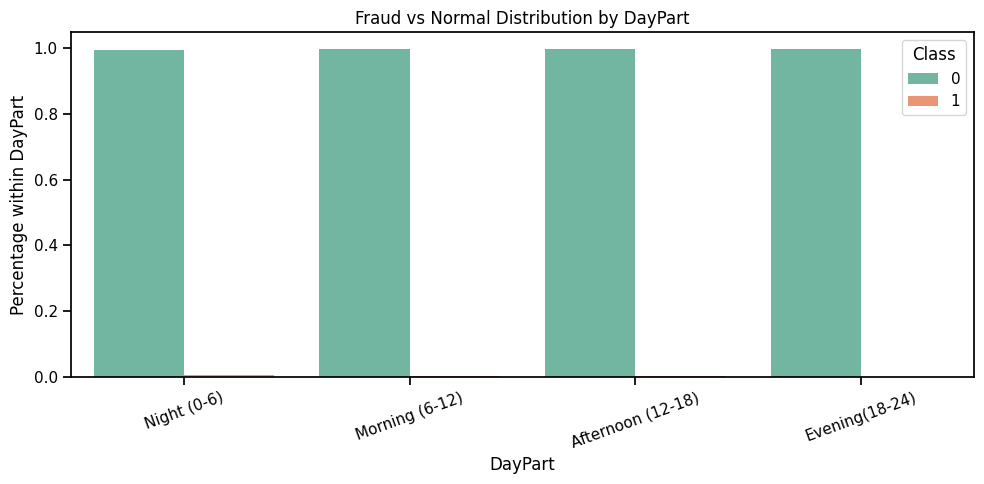

In [27]:
day_counts = df.groupby(["DayPart","Class"]).size().reset_index(name="Count")
day_total  = day_counts.groupby("DayPart")["Count"].transform("sum")
day_counts["Pct"] = day_counts["Count"] / day_total

sns.barplot(x="DayPart", y="Pct", hue="Class", data=day_counts, palette="Set2")
plt.title("Fraud vs Normal Distribution by DayPart")
plt.ylabel("Percentage within DayPart")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


## Cumulative share of fraud by Amount rank


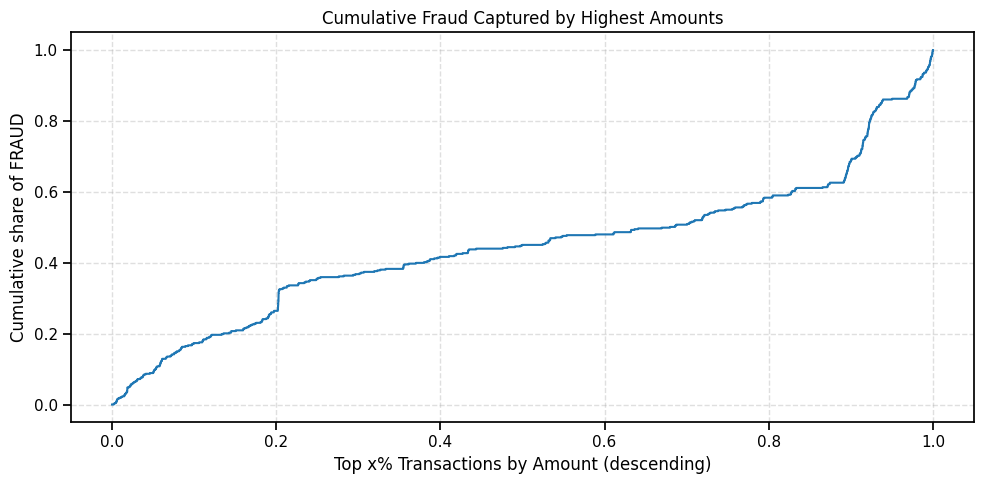

In [28]:
tmp = df[["Amount","Class"]].sort_values("Amount", ascending=False).reset_index(drop=True)
tmp["cum_tx"] = np.arange(1, len(tmp)+1) / len(tmp)
tmp["cum_fraud"] = tmp["Class"].cumsum() / tmp["Class"].sum()

plt.plot(tmp["cum_tx"], tmp["cum_fraud"])
plt.xlabel("Top x% Transactions by Amount (descending)")
plt.ylabel("Cumulative share of FRAUD")
plt.title("Cumulative Fraud Captured by Highest Amounts")
plt.grid(True, ls="--", alpha=0.4)
plt.tight_layout(); plt.show()



## Time-based Split (no look-ahead leakage)

In [29]:
df_sorted = df.sort_values("Time").reset_index(drop=True)
cut = int(0.8 * len(df_sorted))
train_df, test_df = df_sorted.iloc[:cut], df_sorted.iloc[cut:]

# Inner Val Split (time-ordered)
cut_in = int(0.8 * len(train_df))
train__df, val_df = train_df.iloc[:cut_in], train_df.iloc[cut_in:]

X_train , y_train = train__df[features], train__df[target].astype(int)
X_val , y_val = val_df[features] , val_df[target].astype(int) 
X_test,  y_test  = test_df[features],  test_df[target].astype(int)

print("Inner-Train:", len(X_train), "| Val:", len(X_val), "| Test:", len(X_test))
print("Train prevalence:", y_train.mean(), "| Test prevalence:", y_test.mean())


Inner-Train: 181584 | Val: 45396 | Test: 56746
Train prevalence: 0.001910961318177813 | Test prevalence: 0.0013040566735981391


# Utilities: Metrics, Thresholds, Cost

In [30]:
def evaluate_block(y_true, y_score, thr=0.5):
    y_pred = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return dict(
        threshold=float(thr),
        precision=precision_score(y_true, y_pred, zero_division=0),
        recall=recall_score(y_true, y_pred),
        f1=f1_score(y_true, y_pred, zero_division=0),
        roc_auc=roc_auc_score(y_true, y_score),
        auprc=average_precision_score(y_true, y_score),
        brier=brier_score_loss(y_true, y_score),
        tp=int(tp), fp=int(fp), fn=int(fn), tn=int(tn)
    )

def thr_for_precision(y_true, y_score, target_p=0.90):
    ps, rs, ths = precision_recall_curve(y_true, y_score)
    for P, R, T in zip(ps[:-1], rs[:-1], ths):
        if P >= target_p:
            return float(T), float(P), float(R)
    i = np.argmax(ps[:-1] + rs[:-1])  
    return float(ths[i]), float(ps[:-1][i]), float(rs[:-1][i])


def thr_min_cost(y_true , y_score , cost_fp=0.5 , cost_fn=200.0, grid=501):
    best_thr , best_cost = 0.5, float("inf")
    for t in np.linspace(0,1, grid):
        yhat = (y_score >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true ,yhat, labels=[0,1]).ravel()
        cost = fp*cost_fp + fn*cost_fn
        if cost < best_cost:
            best_thr , best_cost = float(t), float(cost)
    return best_thr , best_cost

def realized_cost(y_true, y_score, thr, cost_fp=5, cost_fn=200):
    yhat = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
    return fp*cost_fp + fn*cost_fn


def plot_pr_roc(y_true, y_score ,title):
    ps,rs , _ = precision_recall_curve(y_true , y_score)
    plt.plot(rs, ps)
    plt.axhline(y_true.mean(), ls="--", alpha=0.5)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title} — PR (AP={average_precision_score(y_true,y_score):.3f})")
    plt.grid(True, ls="--", alpha=0.4)
    plt.tight_layout()
    plt.show()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"{title} — ROC (AUC={roc_auc_score(y_true,y_score):.3f})")
    plt.grid(True, ls="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


## Baseline Logistic + RF

[Logistic|Pipeline] VAL AUPRC: 0.7749693650102897
[Logistic|Pipeline] TEST AUPRC: 0.7414676125025982


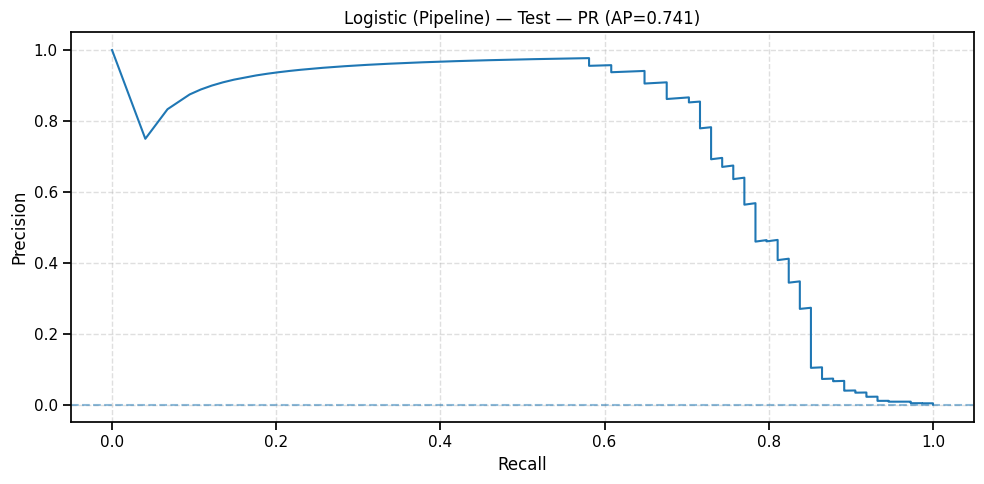

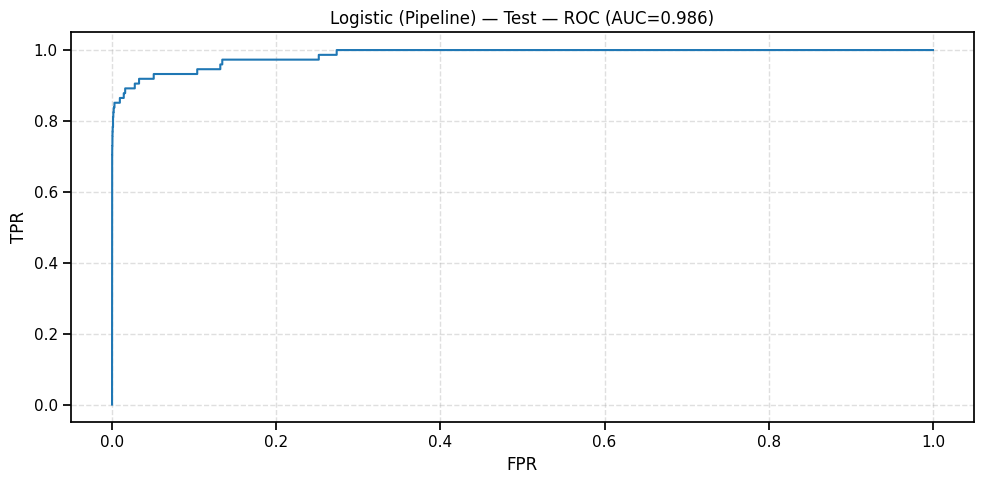

[RF|Pipeline] VAL AUPRC: 0.7563486416023016
[RF|Pipeline] TEST AUPRC: 0.8127961844410134


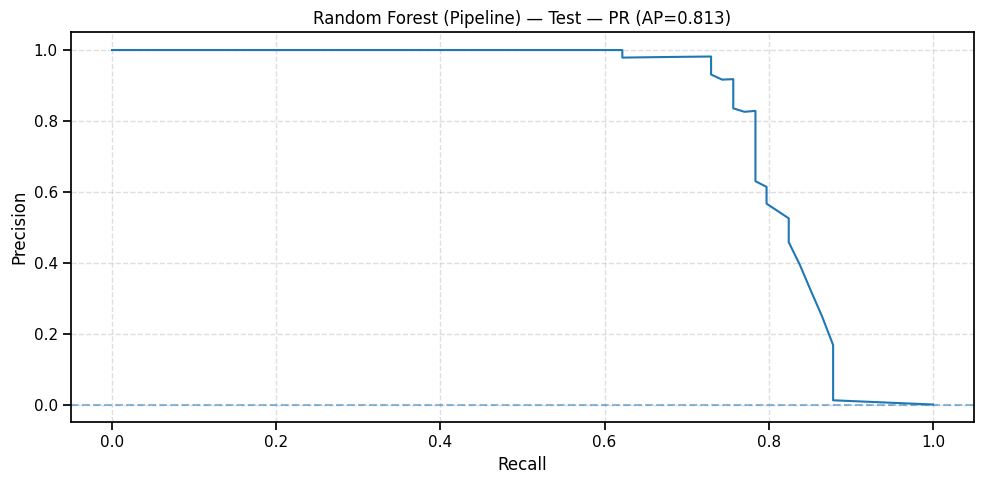

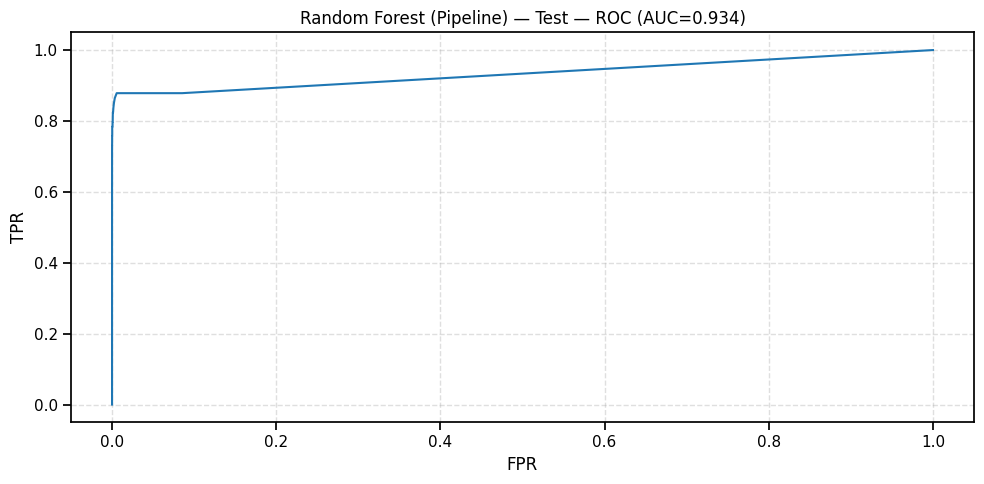

In [31]:
# Logistic Regression
logit_pipe = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=SEED))
])

# Train
logit_pipe.fit(X_train, y_train)

# Val/Test
val_log_proba  = logit_pipe.predict_proba(X_val)[:, 1]
test_log_proba = logit_pipe.predict_proba(X_test)[:, 1]

print("[Logistic|Pipeline] VAL AUPRC:",  average_precision_score(y_val , val_log_proba))
print("[Logistic|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_log_proba))
plot_pr_roc(y_test, test_log_proba, "Logistic (Pipeline) — Test")


# Random Forest
rf_pipe = ImbPipeline(steps=[
    ("clf", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=SEED,
        n_jobs=-1
    ))
])

# Train
rf_pipe.fit(X_train, y_train)

# Val/Test
val_rf_proba  = rf_pipe.predict_proba(X_val)[:, 1]
test_rf_proba = rf_pipe.predict_proba(X_test)[:, 1]

print("[RF|Pipeline] VAL AUPRC:",  average_precision_score(y_val , val_rf_proba))
print("[RF|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_rf_proba))
plot_pr_roc(y_test, test_rf_proba, "Random Forest (Pipeline) — Test")


##  Strong Model — XGBoost 

[XGB|Pipeline] VAL AUPRC: 0.77527187734816
[XGB|Pipeline] TEST AUPRC: 0.7916716106295236


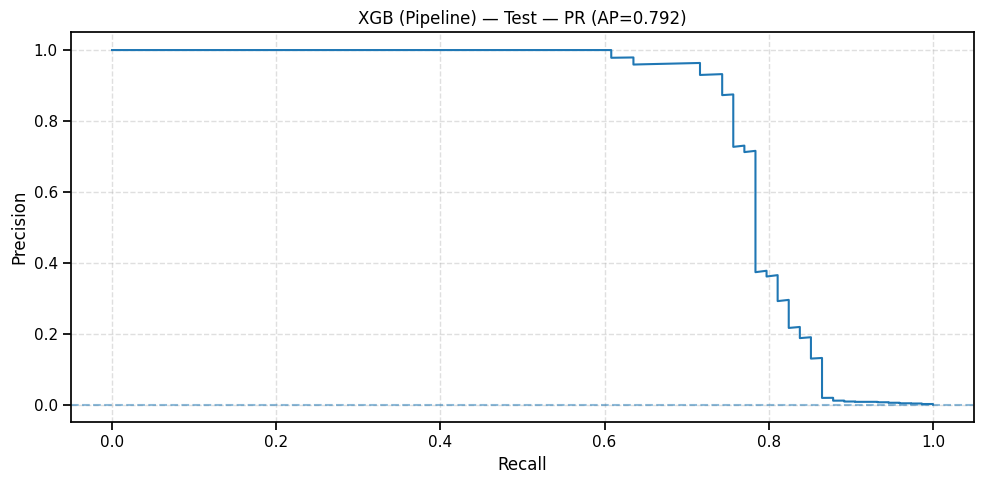

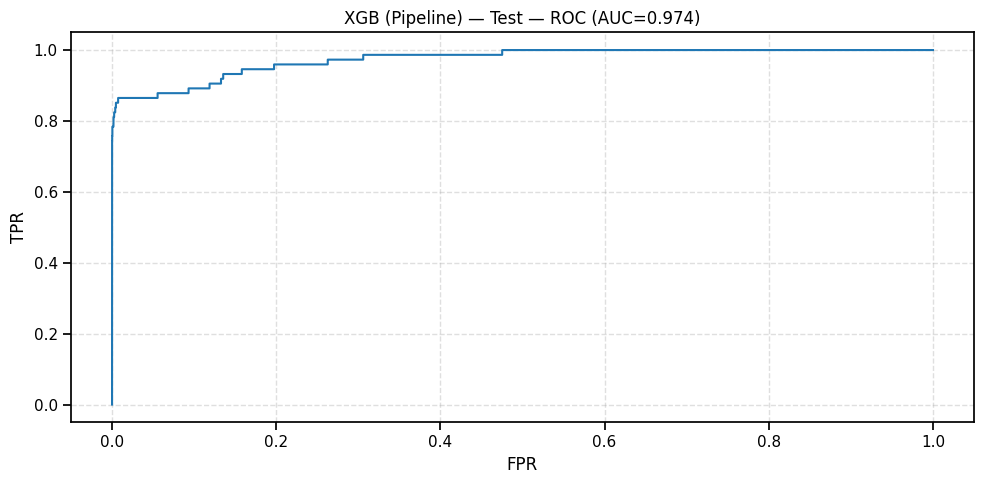

In [32]:
pos, neg = int((y_train==1).sum()), int((y_train==0).sum())
spw = neg / max(1, pos)

xgb_pipe = ImbPipeline(steps=[
    ("model", XGBClassifier(
        n_estimators=600, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        tree_method="hist", random_state=SEED,
        scale_pos_weight=spw, n_jobs=-1, eval_metric="aucpr"
    ))
])
xgb_pipe.fit(X_train, y_train)


val_xgb_proba  = xgb_pipe.predict_proba(X_val)[:, 1]
test_xgb_proba = xgb_pipe.predict_proba(X_test)[:, 1]

print("[XGB|Pipeline] VAL AUPRC:",  average_precision_score(y_val, val_xgb_proba))
print("[XGB|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_xgb_proba))

plot_pr_roc(y_test, test_xgb_proba, "XGB (Pipeline) — Test")



# Calibration (Isotonic) with TimeSeriesSplit on TRAIN

[XGB-Cal|Pipeline] VAL AUPRC: 0.754296695791624
[XGB-Cal|Pipeline] TEST AUPRC: 0.7622617037388646


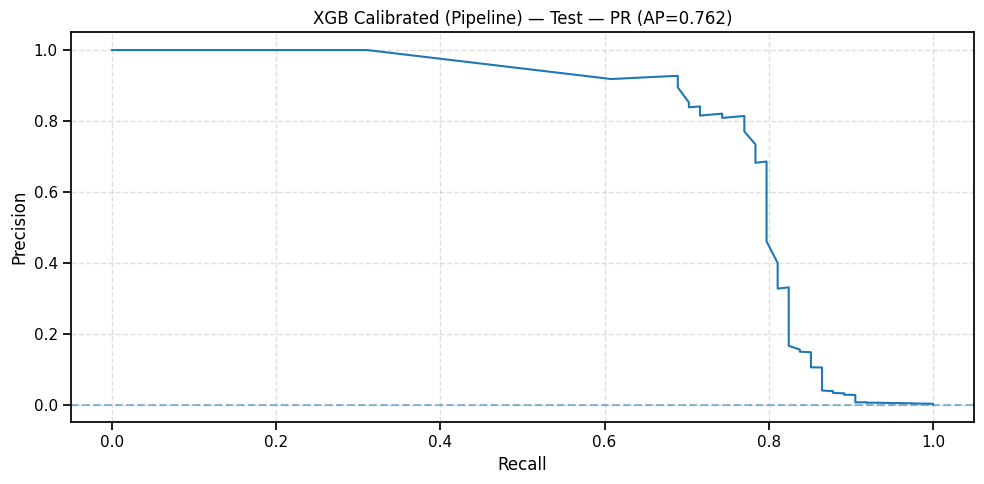

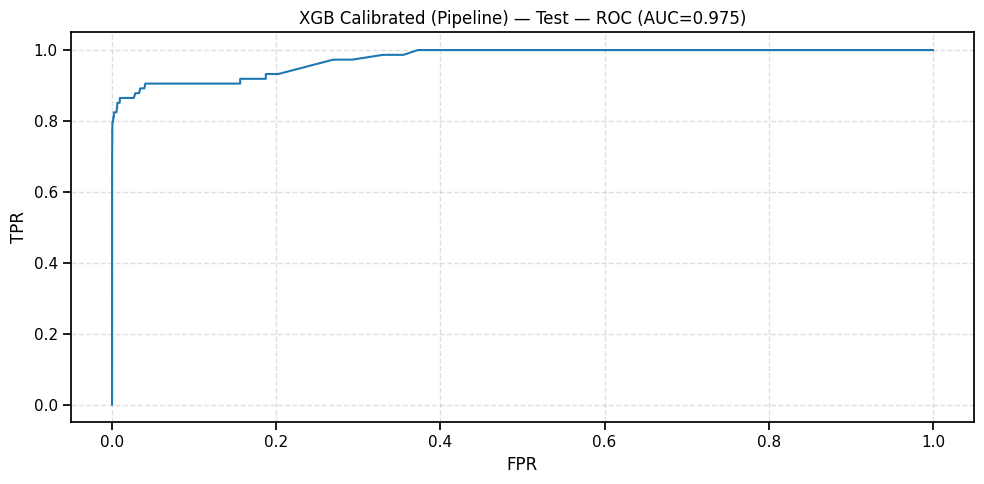

In [33]:


cal_cv = TimeSeriesSplit(n_splits=3)

xgb_cal = CalibratedClassifierCV(
    estimator=xgb_pipe, 
    method="isotonic",
    cv=cal_cv
)
xgb_cal.fit(X_train, y_train)

val_xgb_cal  = xgb_cal.predict_proba(X_val)[:, 1]
test_xgb_cal = xgb_cal.predict_proba(X_test)[:, 1]

print("[XGB-Cal|Pipeline] VAL AUPRC:",  average_precision_score(y_val, val_xgb_cal))
print("[XGB-Cal|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_xgb_cal))
plot_pr_roc(y_test, test_xgb_cal, "XGB Calibrated (Pipeline) — Test")


# Threshold Tuning (choose on Val, evaluate on Test)

In [34]:
thr_p90 , p_at_thr , r_at_thr = thr_for_precision(y_val, val_xgb_cal , target_p= 0.90)
thr_cost , best_cost = thr_min_cost(y_val , val_xgb_cal , cost_fp=5, cost_fn=200)

print(f"[VAL] Thr@P>=90%: thr={thr_p90:.3f}, P={p_at_thr:.3f}, R={r_at_thr:.3f}")
print(f"[VAL] Thr@MinCost: thr={thr_cost:.3f}, Cost={best_cost:.2f}")

FINAL_THR = thr_p90

print("\n===== TEST EVAL @ FINAL_THR =====")
print("Eval@Test (Precision):", evaluate_block(y_test, test_xgb_cal, FINAL_THR))

print("Eval@Test (Min-Cost):", evaluate_block(y_test, test_xgb_cal, thr_cost))


[VAL] Thr@P>=90%: thr=0.866, P=0.972, R=0.673
[VAL] Thr@MinCost: thr=0.204, Cost=2270.00

===== TEST EVAL @ FINAL_THR =====
Eval@Test (Precision): {'threshold': 0.865925927956899, 'precision': 0.92, 'recall': 0.6216216216216216, 'f1': 0.7419354838709677, 'roc_auc': 0.9749354273810796, 'auprc': 0.7622617037388646, 'brier': 0.0006152130889475155, 'tp': 46, 'fp': 4, 'fn': 28, 'tn': 56668}
Eval@Test (Min-Cost): {'threshold': 0.20400000000000001, 'precision': 0.48360655737704916, 'recall': 0.7972972972972973, 'f1': 0.6020408163265306, 'roc_auc': 0.9749354273810796, 'auprc': 0.7622617037388646, 'brier': 0.0006152130889475155, 'tp': 59, 'fp': 63, 'fn': 15, 'tn': 56609}


# Confusion Matrix & Final Eval


In [35]:
final_eval = evaluate_block(y_test, test_xgb_cal, FINAL_THR)
cm = confusion_matrix(y_test, (test_xgb_cal >= FINAL_THR).astype(int))

print("Confusion Matrix @ FINAL_THR\n", cm)
print("Final Eval @ FINAL_THR\n", {k: round(v,4) if isinstance(v,float) else v for k,v in final_eval.items()})

cm_cost = confusion_matrix(y_test, (test_xgb_cal >= thr_cost).astype(int))
print("Confusion Matrix @ Min-Cost thr\n", cm_cost)


Confusion Matrix @ FINAL_THR
 [[56668     4]
 [   28    46]]
Final Eval @ FINAL_THR
 {'threshold': 0.8659, 'precision': 0.92, 'recall': 0.6216, 'f1': 0.7419, 'roc_auc': 0.9749, 'auprc': 0.7623, 'brier': 0.0006, 'tp': 46, 'fp': 4, 'fn': 28, 'tn': 56668}
Confusion Matrix @ Min-Cost thr
 [[56609    63]
 [   15    59]]


## Realized Costs on TEST

In [36]:
cost_p90 = realized_cost(y_test, test_xgb_cal, FINAL_THR, cost_fp=5, cost_fn=200)
cost_min = realized_cost(y_test, test_xgb_cal, thr_cost,  cost_fp=5, cost_fn=200)

print(f"[TEST] Realized Cost @ P>=90% thr ({FINAL_THR:.3f}): {cost_p90:.2f}")
print(f"[TEST] Realized Cost @ Min-Cost thr ({thr_cost:.3f}): {cost_min:.2f}")


[TEST] Realized Cost @ P>=90% thr (0.866): 5620.00
[TEST] Realized Cost @ Min-Cost thr (0.204): 3315.00


## Sampling Comparison 

In [37]:
samplers = {
    "None": None,
    "Under": RandomUnderSampler(random_state=SEED),
    "SMOTE": SMOTE(random_state=SEED),
    "SMOTE+Tomek": SMOTETomek(random_state=SEED),
}

sample_results = []

for name, sampler in samplers.items():
    steps = []
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.extend([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, class_weight=None, random_state=SEED))
    ])

    pipe = ImbPipeline(steps=steps)

    pipe.fit(X_train, y_train)

    val_prob  = pipe.predict_proba(X_val)[:, 1]
    test_prob = pipe.predict_proba(X_test)[:, 1]

    thr90, _, _ = thr_for_precision(y_val, val_prob, 0.90)

    sample_results.append({
        "sampler": name,
        "VAL_AUPRC":  average_precision_score(y_val,  val_prob),
        "TEST_AUPRC": average_precision_score(y_test, test_prob),
        "TEST_ROC_AUC": roc_auc_score(y_test, test_prob),
        "TEST_Recall@P90": evaluate_block(y_test, test_prob, thr90)["recall"],
    })

sample_df = pd.DataFrame(sample_results).sort_values("TEST_AUPRC", ascending=False)
print("\nSampling Comparison (Logistic|Pipelines):\n", sample_df.round(4))



Sampling Comparison (Logistic|Pipelines):
        sampler  VAL_AUPRC  TEST_AUPRC  TEST_ROC_AUC  TEST_Recall@P90
2        SMOTE     0.7714      0.7714        0.9659           0.7297
3  SMOTE+Tomek     0.7714      0.7714        0.9659           0.7297
0         None     0.6706      0.7072        0.9743           0.4595
1        Under     0.2766      0.4476        0.9827           0.7162


# Comparative Summary 

In [38]:
results = pd.DataFrame([
    {
        "Model": "Logistic (Pipeline)",
        "AUPRC": average_precision_score(y_test, logit_pipe.predict_proba(X_test)[:, 1]),
        "ROC-AUC": roc_auc_score(y_test, logit_pipe.predict_proba(X_test)[:, 1]),
        "Brier": brier_score_loss(y_test, logit_pipe.predict_proba(X_test)[:, 1])
    },
    {
        "Model": "RandomForest (Pipeline)",
        "AUPRC": average_precision_score(y_test, rf_pipe.predict_proba(X_test)[:, 1]),
        "ROC-AUC": roc_auc_score(y_test, rf_pipe.predict_proba(X_test)[:, 1]),
        "Brier": brier_score_loss(y_test, rf_pipe.predict_proba(X_test)[:, 1])
    },
    {
        "Model": "XGB (Pipeline)",
        "AUPRC": average_precision_score(y_test, xgb_pipe.predict_proba(X_test)[:, 1]),
        "ROC-AUC": roc_auc_score(y_test, xgb_pipe.predict_proba(X_test)[:, 1]),
        "Brier": brier_score_loss(y_test, xgb_pipe.predict_proba(X_test)[:, 1])
    },
    {
        "Model": "XGB-Calibrated (Pipeline)",
        "AUPRC": average_precision_score(y_test, xgb_cal.predict_proba(X_test)[:, 1]),
        "ROC-AUC": roc_auc_score(y_test, xgb_cal.predict_proba(X_test)[:, 1]),
        "Brier": brier_score_loss(y_test, xgb_cal.predict_proba(X_test)[:, 1])
    },
]).sort_values("AUPRC", ascending=False).reset_index(drop=True)

print("\n=== Model Comparison (Test) ===\n", results.round(4))



=== Model Comparison (Test) ===
                        Model   AUPRC  ROC-AUC   Brier
0    RandomForest (Pipeline)  0.8128   0.9338  0.0004
1             XGB (Pipeline)  0.7917   0.9735  0.0005
2  XGB-Calibrated (Pipeline)  0.7623   0.9749  0.0006
3        Logistic (Pipeline)  0.7415   0.9857  0.0337


In [39]:
# import joblib, json
# joblib.dump(xgb_pipe, "xgb_pipe.joblib")
# joblib.dump(xgb_cal, "xgb_calibrated.joblib")
# json.dump({"FINAL_THR": float(FINAL_THR), "THR_MINCOST": float(thr_cost)}, open("thresholds.json","w"))
